## The two excel sheets were extracted from the campaign_finance_reports.mdb file. Specifically, the Master and Receipts tables were used, since the receipts table contained the contributor details and the master table contained the details of the people/entities that received the contributions

In [2]:
import pandas as pd

mst = pd.read_excel('./Data/master.xlsx')
rpt = pd.read_excel('./Data/receipts.xlsx')

In [99]:
m_cols = mst.columns.values
r_cols = rpt.columns.values
m = mst.to_numpy()
r = rpt.to_numpy()
print(m_cols)
print(r_cols)
print(m.shape)
print(r.shape)

['Report_ID' 'CPF_ID' 'Filing_ID' 'Report_Type_Description' 'Filing_Date'
 'Reporting_Period' 'Report_Year' 'Beginning_Date' 'Ending_Date'
 'Beginning_Balance' 'Receipts' 'Subtotal' 'Expenditures' 'Ending_Balance'
 'Candidate_First_Name' 'Candidate_Last_Name' 'Full_Name' 'District_Code'
 'Office' 'District' 'Comm_Name']
['ID' 'Report_ID' 'Date' 'Contributor_Type' 'First_Name' 'Last_Name'
 'Address' 'City' 'State' 'Zip' 'Occupation' 'Employer'
 'Principal_Officer' 'Contributor_ID' 'Amount']
(166014, 21)
(1042895, 15)


## Extracting rows from the master table based on 'Report_Year' (2016 - 2020)

In [100]:
nums = [i for i in range(len(m_cols))]
col_map = dict(zip(m_cols, nums))
year = col_map['Report_Year']
temp_m = []
for i in range(1, len(m)):
    if m[i][year] >= 2016 and m[i][year] <= 2020:
        temp_m.append(m[i])

In [101]:
print("Number of extracted rows - " + str(len(temp_m)))

Number of extracted rows - 166013


## Performing a merge of the two dataframes based on Report_ID

In [135]:
joined_df = rpt.merge(mst[['Report_ID','Full_Name','Comm_Name','Report_Year','CPF_ID','Filing_Date']], on=('Report_ID'), suffixes=('_l','_r'), validate="m:1")

In [136]:
updated_df = joined_df.drop('Principal_Officer',axis=1)

In [137]:
occupation = ['Nurse','Doctor','Physician','MD','Medical','Hospital','Clinical','RN','Health','Patient']
employer = ['Hospital','Health','Healthcare','Medical']
pacs = []
f = open('./Data/PAC-Names.txt', 'r')
for line in f:
    pacs.append(line.strip(' \n'))
# pacs = ['CVS Health Massachusetts Political Action Committee', 'MA Association of Community Health PAC', \
#         'MA Pol Action Comm for Radiological Health Care', 'Massachusetts Health and Hospital Association Political Action Committee (MHAPAC)',\
#        'Tenet Healthcare Corporation Political Action Committee Massachusetts']

In [138]:
def check_occ(df_val, ignore=None):
    if type(df_val) != str:
        return False
    if ignore != None:
        for x in ignore:
            if x in df_val:
                return False
    for x in occupation:
        if x in df_val or df_val in x:
            return True
def check_emp(df_val, ignore=['Hospitality']):
    if type(df_val) != str:
        return False
    if ignore != None:
        for x in ignore:
            if x in df_val:
                return False
    for x in employer:
        if x in df_val or df_val in x:
            return True
def check_pacs(df_val, ignore=None):
    if type(df_val) != str:
        return False
    if ignore != None:
        for x in ignore:
            if x in df_val:
                return False
    for x in pacs:
        if x in df_val or df_val in x:
            return True

In [168]:
filtered_df = updated_df[updated_df['Occupation'].apply(check_occ) | updated_df['Employer'].apply(check_occ) | updated_df['Occupation'].apply(check_emp) | updated_df['Employer'].apply(check_emp) | updated_df['Last_Name'].apply(check_occ) | updated_df['Last_Name'].apply(check_pacs) | updated_df['Full_Name'].apply(check_pacs) | updated_df['Full_Name'].apply(check_occ)]
filtered_df.shape

(86635, 19)

In [169]:
filtered_df.to_csv('output.csv')

## As above, we extract the relevant rows of the receipts table as well, while also applying the healthcare keywords as additional filters.

## For the filters, we matched based on Occupation, Employer and Last_Name (some PAC's would have their business name listed in that column)

In [151]:
import math
nums2 = [i for i in range(len(r_cols))]
col_map2 = dict(zip(r_cols, nums2))
year = col_map2['Date']
occ = col_map2['Occupation']
emp = col_map2['Employer']
pac = col_map2['Last_Name']
temp_r = []
for i in range(1, len(r)):
    if r[i][year] >= '2016' and r[i][year] <= '2020':
        e = r[i][emp]
        o = r[i][occ]
        p = r[i][pac]
        flag = 0
        if type(o) == str:
            for job in occupation:
                if job in o or o in job:
                    temp_r.append(r[i])
                    flag = 1
                    break
        if flag == 1:
            continue
        if type(e) == str:
            for boss in employer:
                if 'Hospitality' in e:
                    flag = 1
                    break
                if boss in e or e in boss:
                    temp_r.append(r[i])
                    flag = 1
                    break
        if flag == 1:
            continue
        if type(p) == str:
            for poc in pacs:
                if poc in p or p in poc:
                    temp_r.append(r[i])
                    flag = 1
                    break
        if flag == 1:
            continue
        if type(p) == str:
            for boss in employer:
                if boss in p or p in boss:
                    temp_r.append(r[i])
                    flag = 1
                    break

In [152]:
print("Total number of transactions - " + str(len(temp_r)))

Total number of transactions - 32659


## Here we analyze the ranges of the contributions and draw a simple bar graph based on the results

## On the side, we are also extracting values from the 'Report_ID' column to match with the master table

In [157]:
received = col_map2['Amount']
ids = col_map2['Report_ID']
yrs = {}
l = {'0-25':0,'25-100':0,'101-1000':0,'1001-10000':0,'10001-100000':0,'100001-1000000':0,'1000001+':0}
m = 0
id_list = []
m_i = []
for i in temp_r:
    if i[ids] not in id_list:
        id_list.append(i[ids])
    amt = i[received]
    if m < amt:
        m_i = i
        m = amt
    if amt <= 25:
        l['0-25'] += 1
    elif amt >= 25 and amt <= 100:
        l['25-100'] += 1
    elif amt > 100 and amt <= 1000:
        l['101-1000'] += 1
    elif amt > 1000 and amt <= 10000:
        l['1001-10000'] += 1
    elif amt > 10000 and amt <= 100000:
        l['10001-100000'] += 1
    elif amt > 100000 and amt <= 1000000:
        l['100001-1000000'] += 1
    else:
        print(i)
        l['1000001+'] += 1

[12825943 673113 '2018-09-26' 'OTHER' nan
 'Massachusetts Health & Hospital Association' '500 District Ave'
 'Burlington' 'MA' '01803' nan nan 'Steve Walsh' nan 1300000.0]
[12847661 674901 '2018-10-03' 'OTHER' nan
 'Massachusetts Health & Hospital Association' '500 District Ave'
 'Burlington' 'MA' '01803' nan nan 'Steve Walsh' nan 1800000.0]
[12847664 674901 '2018-10-09' 'OTHER' nan
 'Massachusetts Health & Hospital Association' '500 District Ave'
 'Burlington' 'MA' '01803' nan nan 'Steve Walsh' nan 2650000.0]
[12916762 677153 '2018-05-15' 'OTHER' nan
 'Massachusetts Health & Hospital Association' '500 District Ave'
 'Burlington' 'MA' '01803' nan nan 'Steve Walsh' nan 2500000.0]
[12917154 677154 '2018-09-12' 'OTHER' nan
 'Massachusetts Health & Hospital Association' '500 District Ave'
 'Burlington' 'MA' '01803' nan nan 'Steve Walsh' nan 2400000.0]
[13082180 691799 '2018-10-16' 'OTHER' nan
 'Massachusetts Health & Hospital Association' '500 District Ave'
 'Burlington' 'MA' '01803' nan n

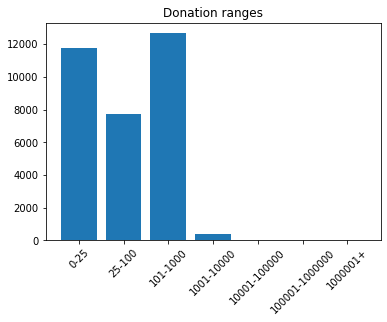


Calculated ranges
{'0-25': 11789, '25-100': 7744, '101-1000': 12664, '1001-10000': 398, '10001-100000': 37, '100001-1000000': 20, '1000001+': 7}


In [171]:
import matplotlib.pyplot as plt
plt.bar(list(l), l.values())
plt.xticks(list(l), rotation='45')
plt.title('Donation ranges')
plt.show()
# print("Highest contributor - " + str(m_i))
print("\nCalculated ranges")
print(l)

## Extract rows from the master table based on 'Report_ID' and also extracting unique recipients based on 'CPF_ID'

In [115]:
ids = col_map['Report_ID']
cpf = col_map['CPF_ID']
name = col_map['Full_Name']
amount = col_map['Receipts']
cp = {}
health_temp = []
for i in temp_m:
    if i[ids] in id_list:
        health_temp.append(i)
        if i[cpf] not in cp:
            cp[i[cpf]] = {}
            cp[i[cpf]]['Name'] = i[name]
            cp[i[cpf]]['Amount'] = i[amount]
        else:
            cp[i[cpf]]['Amount'] += i[amount]

In [116]:
print("Number of unique recipients related to healthcare industry - " + str(len(cp)))
x = []
for i in cp:
    x.append((cp[i]['Name'],cp[i]['Amount']))
x.sort(key = lambda x: x[1], reverse=True)
print("\nTop 10 recipients\n")
for i in x[:10]:
    print(i)

Number of unique recipients related to healthcare industry - 1039

Top 10 recipients

('Coalition to Protect Patient Safety', 25800788.790000003)
('Save Our Public Schools', 15406896.5)
('Committee to Ensure Safe Patient Care', 12298919.81)
('YES on 4', 6065697.0)
('Charles D. Baker', 5783997.62)
('Freedom for All Massachusetts, Inc.', 5530348.4)
('Maura T. Healey', 3008623.719999999)
('Martin J. Walsh', 2930438.9200000004)
('Karyn E. Polito', 2892809.67)
('Campaign for Fair Access to Quality Public Schools', 2292183.11)


## Extracting the total amount received by year, considering only the reports tagged as 'Deposit Report'

In [96]:
y = {}
re = col_map['Receipts']
yr = col_map['Report_Year']
desc = col_map['Report_Type_Description']
for i in health_temp:
    if i[desc] != 'Deposit Report':
#     if i[desc] != 'Deposit Report' and i[desc] != 'Late Contribution Report' and i[desc] != 'Bank Report':
# #         print(i[desc])
        continue
    amt = i[re]
    if i[yr] not in y:
        y[i[yr]] = 0
    if not math.isnan(amt):
        y[i[yr]] += int(amt)

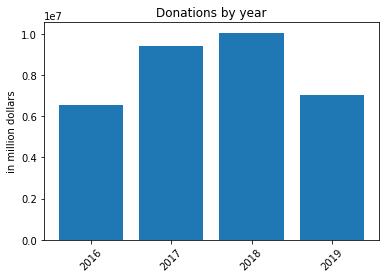

In [97]:
import matplotlib.pyplot as plt
plt.bar(list(y), y.values())
plt.xticks(list(y), rotation='45')
plt.title('Donations by year')
plt.ylabel('in million dollars')
plt.show()